In [11]:
import numpy as np
import autograd.numpy as npa

import legume
import legume_backend
from itertools import product

%load_ext autoreload
%autoreload 2

# array_id = int(sys.argv[1])

phc_size_list = [16]
adam_step_size_list =  [0.04]
gmax_list = [2]
kpoints_list = [2]
Q_target_array = [4]
gaussian_width_array = [0.35]

adam_step_size, gmax, kpoints, Q_target, phc_size, gaussian_width = list(product(adam_step_size_list, gmax_list, kpoints_list, Q_target_array, phc_size_list, gaussian_width_array))[0]

params_loss_log_file_name = f"weights_520_14.10.2024/L3_520nm_weights_step_size_{int(adam_step_size * 10000)}_gmax_{gmax}_kpoints_{kpoints}_loss_V2_Q_target_10e{Q_target}_phc_size_{phc_size}_ffgauss_{gaussian_width}.npy"

# Initialize PhC
Nx, Ny = phc_size, phc_size
hole_radius, slab_thickness, refractive_index, x_shift = legume_backend.L3_params_520() # change cavity parameters

x_pos, y_pos = legume_backend.phc_cavity_holes_array('L3', Nx, Ny)
x_pos[0] = x_pos[0] + x_shift

eigvec_file = f"./Legume_eigenvectors/L3_520nm_eigvecs_gmax={gmax}.npy"
eigvec = np.load(eigvec_file, allow_pickle = True)

def objective_function(parameters, *args):
    
    dx = parameters[0: len(x_pos)]
    dy = parameters[len(x_pos):]
    
    gaussian_width = args[0]

    L3_phc = legume_backend.design_phc(Nx, Ny, x_pos, y_pos, hole_radius, slab_thickness, refractive_index, dx, dy)

    # Run the simulation
    # (gme, f_imag_array, direction_ratio_array, indmode) = legume_backend.gme_cavity(L3_phc, Nx, Ny, gaussian_width, gmax = gmax, kpoints = kpoints_array, options = options)
    (gme, f_imag_array, direction_ratio_array, indmode) = legume_backend.gme_cavity_dot(L3_phc, gaussian_width, eigvec, gmax, kpoints = kpoints_array, gme_options = gme_options)
    # (gme, f_imag_array, direction_ratio_array, indmode) = legume_backend.gme_cavity_field(L3_phc, num_modes, slab_thickness, gmax = gmax , kpoints = kpoints_array, options = options)
    
    Q = gme.freqs[0, indmode]/2/npa.mean(f_imag_array)
    direction_ratio = npa.mean(direction_ratio_array)
    
    direction_ratio_history.append(direction_ratio._value)
    quality_factor_history.append(Q._value)
    
    print(f"Quality factor = {np.round(quality_factor_history[-1],2)}, direction ratio = {direction_ratio_history[-1]}")

    
    if quality_factor_history[-1] < 0.9*10**(Q_target-2):
        return (npa.pi/4 - npa.arctan(Q/10**(Q_target-2)))**2 + (1 - direction_ratio)**2
    elif quality_factor_history[-1] > 0.9*10**(Q_target-2) and quality_factor_history[-1] < 0.9*10**(Q_target-1):
        return (npa.pi/4 - npa.arctan(Q/10**(Q_target-1)))**2 + (1 - direction_ratio)**2
    else:
        return (npa.pi/4 - npa.arctan(Q/10**(Q_target)))**2 + (1 - direction_ratio)**2
    
# To compute gradients, we need to set the `legume` backend to 'autograd'
legume.set_backend('autograd')

direction_ratio_history = ([])
quality_factor_history = ([])

# Set some GME options
# options = {'gmode_inds': [0], 'verbose': False, 'eig_solver': 'eigsh',
#           'numeig': Nx*Ny+1, 'gradients': grad_calc_method, 'compute_im': False}

num_modes = 15
gme_options = {'gmode_inds': [0], 'verbose': False, 'gradients': 'approx', 'numeig': num_modes,
                'eig_sigma': 0.40, 'eig_solver': 'eigsh', 'compute_im': False}


kpoints_array = legume_backend.get_kpoints(Nx, Ny, nkx = kpoints, nky = kpoints)

# Initialize an optimization object
opt = legume_backend.Minimize_Neelesh(objective_function)

# Starting parameters are the un-modified cavity
pstart = np.random.randn(len(x_pos) + len(y_pos)) * 0.005

Nepochs = 150

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# Run an 'adam' optimization
(p_opt, loss_function, param_history, t_elapsed_history) = opt.adam(pstart, step_size = adam_step_size, Nepochs=Nepochs, bounds= [-0.1, 0.1], args = [gaussian_width])

Quality factor = 1264.06, direction ratio = 0.06740984704213893
Epoch:    1/ 150 | Duration:  44.63 secs | Objective: 1.304874e+00


ValueError: arange: cannot compute length

In [3]:
# Flatten arrays; Save paramater history, loss history and training log
param_history, loss_function, t_elapsed_history = np.array(param_history), np.array(loss_function), np.array(t_elapsed_history)
param_history = param_history.flatten()
loss_function = loss_function.flatten()
t_elapsed_history = t_elapsed_history.flatten()
direction_ratio_history = np.asarray(direction_ratio_history).flatten()
quality_factor_history = np.asarray(quality_factor_history).flatten()
data_to_save = np.asarray([param_history, loss_function, t_elapsed_history, direction_ratio_history, quality_factor_history], dtype = 'object')
# print (data_to_save)
np.save(params_loss_log_file_name, data_to_save)

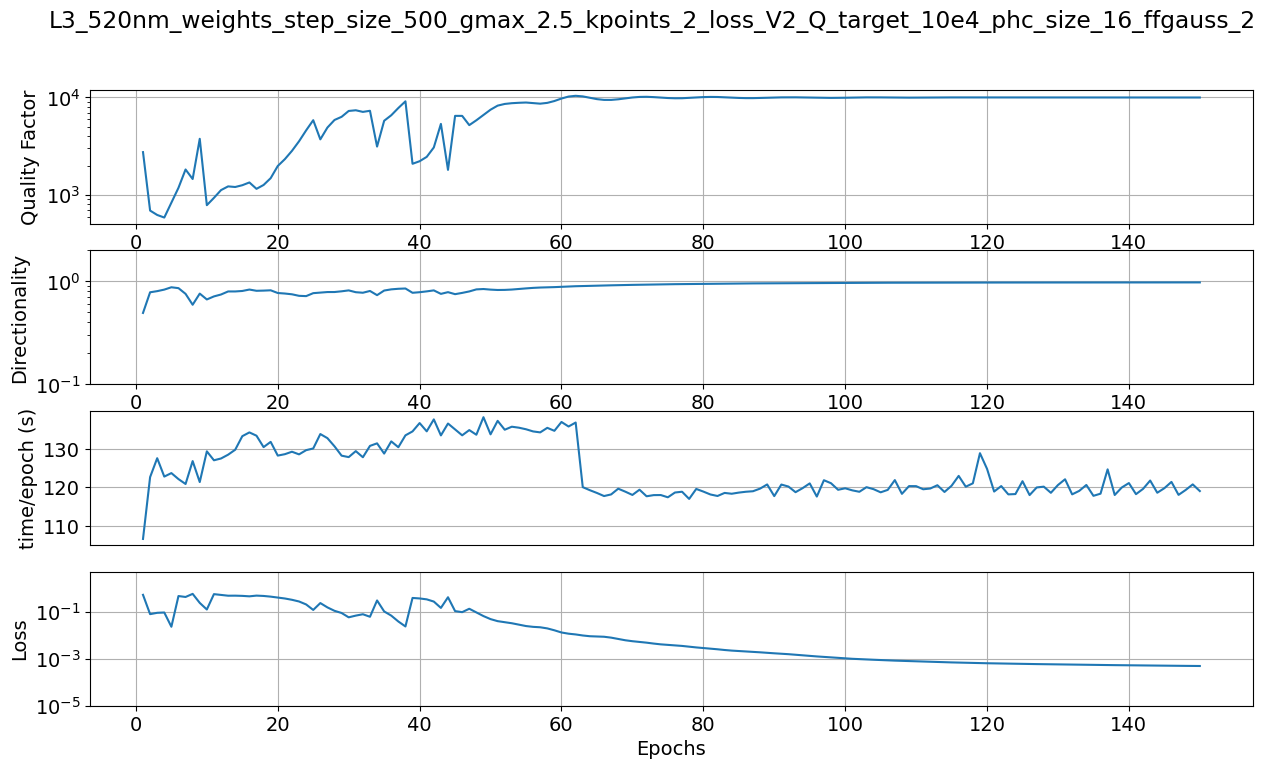

In [4]:
legume_backend.plotting_with_weights(params_loss_log_file_name)

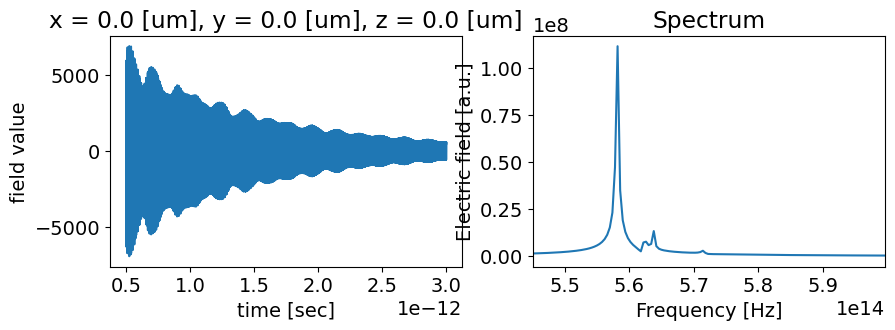

                     decay            Q    amplitude     phase     error
freq                                                                    
5.579334e+14  8.809833e+11  1989.594422  2620.475682 -1.749930  0.003148
5.713353e+14  1.860473e+12   964.756127    82.098229  0.724599  0.037293
6.414355e+14  3.313415e+12   608.172909   173.507882  0.400732  0.025364
Resonant wavelength =  537.33 nm, Quality factor =  1989.594421638064
Closest wavelength =  537.76 nm


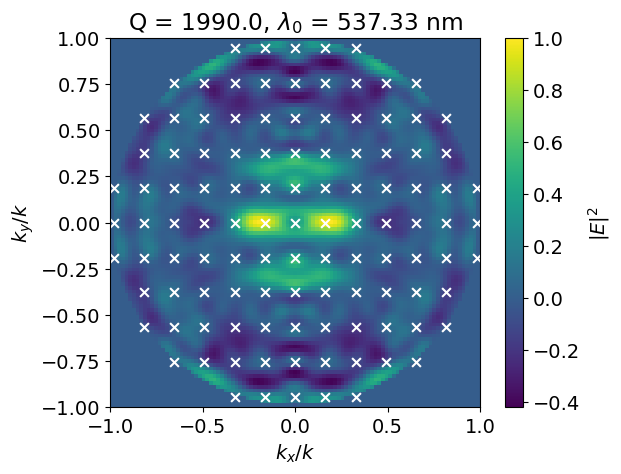

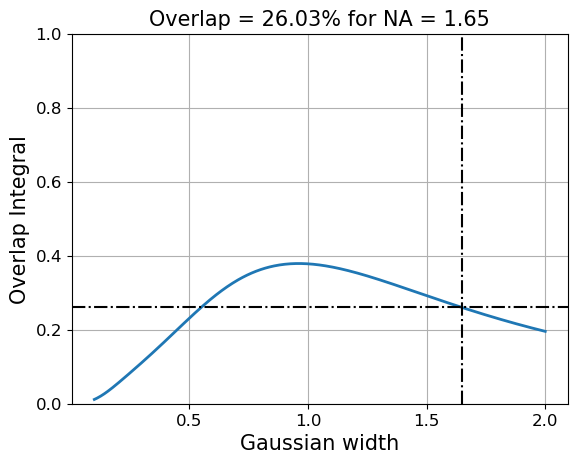

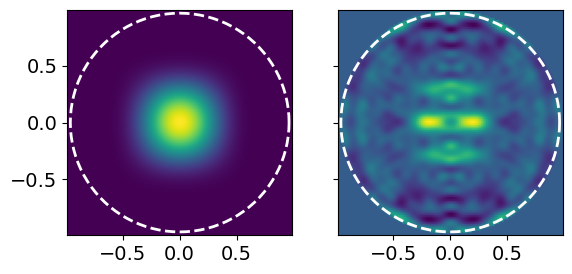

In [5]:
import tidy3D_backend

tidy3D_backend.run_FDTD(params_loss_log_file_name, gaussian_width)